In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
import scipy
import scipy as stats
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS
import glob


#copy and paste code cite vespa anyways

In [1]:
file = r'C:\Users\astro\SSG_Spectra\Metallicities\ssg_table1.txt'
gaia_ids = np.genfromtxt(file, usecols= 0, dtype = str)
gaia_ids2 = list(np.genfromtxt(file, usecols= 0, dtype = np.int64))
gaia_ids = str(list(gaia_ids)).strip('[]')
#classif = np.genfromtxt(file, usecols= 18, dtype = str)

#print(gaia_ids)


#print(df.columns.tolist())

In [2]:
#Do Not Mess with Query

query_text = f'''SELECT TOP 10000 *
FROM gaiadr3.gaia_source 
WHERE gaiadr3.gaia_source.source_id IN ({gaia_ids}) AND
    rv_template_fe_h IS NOT null''' 
job = Gaia.launch_job(query_text) 
gaia_data = job.get_results()


In [3]:
print(job)

<Table length=1371>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique within a particular Data Release)     0
          

In [4]:
gaia_data['SOURCE_ID', 'ra','dec', 'rv_template_fe_h'] #Create tables 

SOURCE_ID,ra,dec,rv_template_fe_h
,deg,deg,dex
int64,float64,float64,float32
18910470421959808,40.65095558618673,7.290585245493459,-0.25
34148700855166720,43.83780066505116,15.656337721802666,0.0
54254958891842816,51.01410355127157,15.47253974991323,-0.25
65719566637012992,58.44664614163716,23.83542417189985,-0.5
83339790224838784,41.88059999692063,17.268300455125537,-0.5
104747552200480256,29.898274929205545,23.814618108691676,-1.0
105419839137199360,31.677830099851665,25.532028797336345,-0.25
105632766435603072,30.049806998655388,25.841204074838135,-1.0


In [5]:
#ra = gaia_data['ra']
#dec = gaia_data['dec']
c = SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'], frame='icrs')
ra = c.ra.wrap_at(180 * u.deg).radian
dec = c.dec.radian
metallicity = np.array(gaia_data['rv_template_fe_h'], dtype = float)

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
m_G = np.array(gaia_data['phot_g_mean_mag'], dtype = float)
uncorr_bp_rp = np.array(gaia_data['bp_rp'], dtype = float)
distance = np.array(dist, dtype = float)

In [6]:
av_tot = np.genfromtxt(file, usecols=16, dtype=float)
av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_data['SOURCE_ID']], 
              dtype = float)
ag = av*0.789
Ebp_rp = ag/1.890 #ag/e(bp=rp) = 1.890
bp_rp = uncorr_bp_rp + Ebp_rp
M_G = -5*np.log10(distance) + m_G - ag + 5 #m-M = 5log(d) - 5 + Av

# APOGEE DATA

In [7]:
#Check Samples
import astropy.io.fits as pyfits
apogee_file = r'C:\Users\astro\SSG_Spectra\Metallicities\Leiner_Patton_overlap2.txt'
apogee_gaiaids = np.genfromtxt(apogee_file, usecols= 7, dtype = np.int64)
apogee_star = np.genfromtxt(apogee_file, usecols= 8, dtype=str)
apogee_ids = np.genfromtxt(apogee_file, usecols= 0, dtype=str)
apogee_class = np.genfromtxt(apogee_file, usecols= 6, dtype=str)
#Apogee data
allStar_localpath = r'C:\Users\astro\SSG_Spectra\Metallicities\allStar-dr17-synspec_rev1.fits'
allStar_fits = pyfits.open(allStar_localpath)
allStar = allStar_fits[1].data #Takes data is HDU 1 and assigns it to allStar
#allStar2 = allStar_fits[0].data #Takes data is HDU 1 and assigns it to allStar

In [13]:
print(allStar_fits[1].header)


XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 5410 / length of dimension 1                          NAXIS2  =               733901 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  234 / number of table fields                         TTYPE1  = 'FILE    '                                                            TFORM1  = '64A     '                                                            TTYPE2  = 'APOGEE_ID'                                                           TFORM2  = '30A     '                                                            TTYPE3  = 'TARGET_ID'                   

In [21]:
print(allStar_fits[1].header['XTENSION'])

BINTABLE


In [15]:
#allStar.dtype.fields
#allStar2.dtype.fields

In [16]:
samp_mask = [any(k == apogee_ids) for k in allStar['APOGEE_ID']]
#samp_mask2 = [any(k == apogee_ids) for k in allStar2['APOGEE_ID']]

In [17]:
apogee_samp = np.array(allStar['APOGEE_ID'][samp_mask])
apogee_metallicites = np.array(allStar['Fe_H'][samp_mask])

# Gaia-Apogee Comparison

In [18]:
gaia_comp = [any(k == apogee_gaiaids) for k in gaia_data['SOURCE_ID']]

In [19]:
#Compare Samples
target_list = list(apogee_ids)
target_gaia = list(gaia_data[gaia_comp]['SOURCE_ID'])

star_list = []
gaia_feh = []
apogee_feh = []
comp_star_class = []
gaia_feh2 = []
for i in range(len(apogee_samp)):
    target = apogee_samp[i]
    target_index = target_list.index(target)
    gaia_target = apogee_gaiaids[target_index]
    #print(target, apogee_ids[target_index], gaia_target)
    if gaia_target in target_gaia:
        gaia_index = target_gaia.index(gaia_target)
        gaia_feh.append(gaia_data[gaia_comp]['rv_template_fe_h'][gaia_index])
        gaia_feh2.append(gaia_data[gaia_comp]['mh_gspphot'][gaia_index])
        star_list.append(apogee_star[target_index])
        apogee_feh.append(apogee_metallicites[i])
        comp_star_class.append(apogee_class[target_index])

In [20]:
diff_mets =[]

print('Star','\t\t\t\t|', 'Class', '|\t', 'Gaia [Fe/H]', '|\t', 'Apogee [Fe/H]')
print('---------------------------------------------------------------------------------------------------------')
for i in range(len(star_list)):
    diff_met = apogee_feh[i] - gaia_feh[i]
    diff_mets.append(abs(diff_met))
    if len(star_list[i]) <= 5:
        spacing = '\t\t\t\t|'
    elif len(star_list[i]) <= 14 :
        spacing = '\t\t\t|'
    elif len(star_list[i]) <= 22:
        spacing = '\t\t|'
    else:
        spacing = '\t|'
    print(star_list[i], spacing, comp_star_class[i], 
          '\t|\t', gaia_feh[i], '\t\t|\t', round(apogee_feh[i], 2), '\t|\t', round(diff_met, 2))

Star 				| Class |	 Gaia [Fe/H] |	 Apogee [Fe/H]
---------------------------------------------------------------------------------------------------------
GSC00010-00058 			| RS 	|	 0.0 		|	 0.09 	|	 0.09
FPPsc 				| RS 	|	 0.0 		|	 -0.34 	|	 -0.34
ZTFJ021739.63+532644.4 		| SSG 	|	 -1.0 		|	 -0.01 	|	 0.99
CSS_J044133.0+074229 		| RS 	|	 0.0 		|	 -0.19 	|	 -0.19
CSS_J070715.7+365254 		| RS 	|	 0.0 		|	 0.06 	|	 0.06
KNCnc 				| SSG 	|	 -1.5 		|	 -0.17 	|	 1.33
FMLyn 				| RS 	|	 0.0 		|	 0.14 	|	 0.14
GSC03454-00008 			| SSG 	|	 -0.25 		|	 -0.11 	|	 0.14
GSC03454-00008 			| SSG 	|	 -0.25 		|	 -0.1 	|	 0.15
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.2 	|	 0.05
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.23 	|	 0.02
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.15 	|	 0.1
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.25 	|	 -0.0
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.24 	|	 0.01
ROTSE1J125818.06+282517.7 	| RS 	|	 -0.25 		|	 -0.23 	|	 0.02
ROTSE1J125818.0

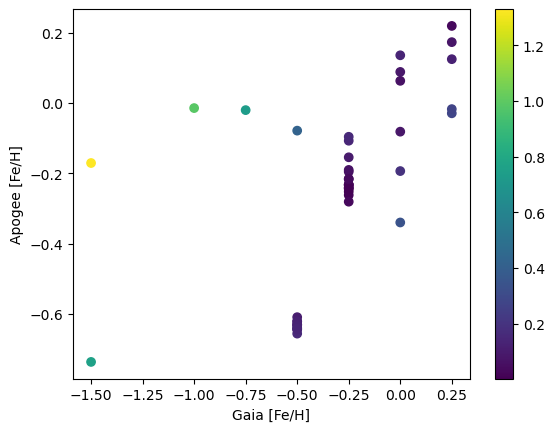

In [21]:
fig, ax  = plt.subplots()
cs = ax.scatter(gaia_feh, apogee_feh, c=diff_mets)
ax.set_xlabel('Gaia [Fe/H]')
ax.set_ylabel('Apogee [Fe/H]')
cb = fig.colorbar(cs)

#cb.set_label('[Fe/H]')

In [23]:
for i in range(len(star_list)):
    print(star_list[i])

GSC00010-00058
FPPsc
ZTFJ021739.63+532644.4
CSS_J044133.0+074229
CSS_J070715.7+365254
KNCnc
FMLyn
GSC03454-00008
GSC03454-00008
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ROTSE1J125818.06+282517.7
ZTFJ130038.44+434017.2
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
NTCom
MSBoo
ZTFJ152224.63+354541.1
QZBoo
QZBoo
ZTFJ162331.01+514729.5
ZTFJ180128.48+595151.5
V0669Lyr
ASASJ194031+4345.3
ZTFJ213303.01+011608.2


In [24]:
comp_file = r'C:\Users\astro\SSG_Spectra\Metallicities\gaia-apogee_comp.csv'

df_comp = pandas.read_csv(comp_file, delimiter = ',')

print(df_comp.columns.tolist())

['star', 'gaia_feh', 'gaia_feh2', 'apogee_feh', 'feh_diff']


In [27]:
stars_comp = np.array(df_comp['star'], dtype = str)
comp_gaia_feh = np.array(df_comp['gaia_feh'], dtype = float)
comp_gaia_feh2_1 = np.array(df_comp['gaia_feh2'], dtype = str)
comp_apogee_feh = np.array(df_comp['apogee_feh'], dtype = float)
comp_feh_diff = np.array(df_comp['feh_diff'], dtype = float)

In [29]:
not_null = (comp_gaia_feh2 != '--')

comp_gaia_feh2 = np.array(comp_gaia_feh2_1[not_null], dtype = float)

In [30]:
fe_h_filt = comp_gaia_feh >= -0.5

linregress_feh = scipy.stats.linregress(comp_gaia_feh[fe_h_filt], comp_apogee_feh[fe_h_filt])
A_feh, B_feh, r_feh, pval_feh, sterr_feh  = linregress_feh

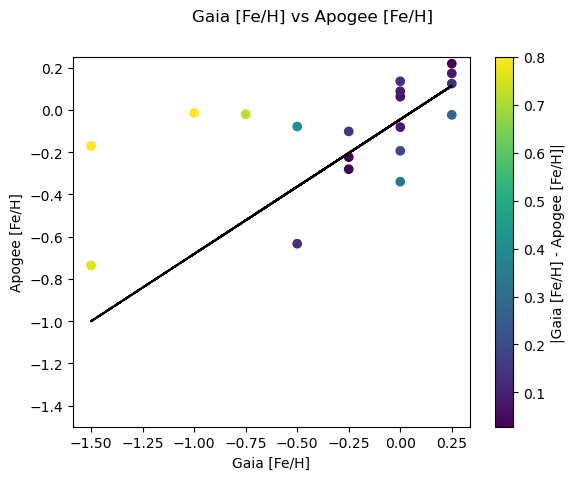

In [31]:
fig, ax  = plt.subplots()
fig.suptitle('Gaia [Fe/H] vs Apogee [Fe/H]')
ax.plot(comp_gaia_feh, A_feh*comp_gaia_feh + B_feh, ls = '--', color = 'black')#trendline
cs = ax.scatter(comp_gaia_feh, comp_apogee_feh, c=comp_feh_diff, vmax = 0.8)
#ax.set_xlim(-2.00, 1.0)
ax.set_ylim(-1.50, 0.25)
ax.set_xlabel('Gaia [Fe/H]')
ax.set_ylabel('Apogee [Fe/H]')
cb = fig.colorbar(cs)
cb.set_label('|Gaia [Fe/H] - Apogee [Fe/H]|')

#cb.set_label('[Fe/H]')

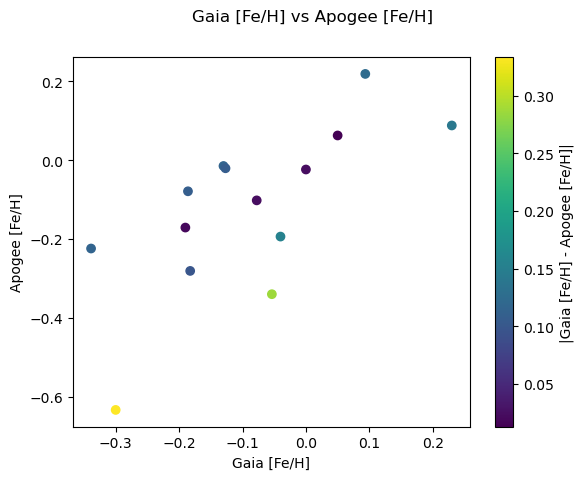

In [36]:
fig, ax  = plt.subplots()
fig.suptitle('Gaia [Fe/H] vs Apogee [Fe/H]')
#ax.plot(comp_gaia_feh2, 1*comp_gaia_feh2 + 0, ls = '--', color = 'black')#trendline
cs = ax.scatter(comp_gaia_feh2, comp_apogee_feh[not_null], c=abs(comp_gaia_feh2 - comp_apogee_feh[not_null]))
##ax.set_xlim(-2.00, 1.0)
#ax.set_ylim(-1.50, 0.25)
ax.set_xlabel('Gaia [Fe/H]')
ax.set_ylabel('Apogee [Fe/H]')
cb = fig.colorbar(cs)
cb.set_label('|Gaia [Fe/H] - Apogee [Fe/H]|')

#cb.set_label('[Fe/H]')